In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# Mount pra acessar os dados do drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

## Carregando o dataset

Primeiramente, carregamos o dataset e damos merge nos dados. Como tínhamos várias colunas de diferentes arquivos com o mesmo nome, resolvemos mudar os nomes de tais colunas de acordo com o seu tipo. 

In [ ]:
#Muda o nome da colunas, de acordo com o seu tipo
def change_column_name(df, f_type):
    for feature in df:
        if feature != 'user_id' and feature != 'tweet_id' and feature != 'tweet_user_id':
           df = df.rename(columns={feature: f_type +'_' + feature})

    return df

In [ ]:
#carrega os csvs do user e dá merge nas tabelas
def upload_users():
    path = '/content/drive/MyDrive/Colab Notebooks/task 5/Dataset/Users/'

    users = pd.read_csv(path + 'users.csv')
    
    users_vectorized_descriptions = pd.read_csv(path + 'user_vectorized_descriptions.csv')
    users_vectorized_descriptions = change_column_name(users_vectorized_descriptions, 'descrip')

    users_vectorized_profile_images = pd.read_csv(path + 'user_vectorized_profile_images.csv')
    users_vectorized_profile_images = change_column_name(users_vectorized_profile_images, 'prof_img')

    #merge das tabelas
    users = users.merge(users_vectorized_descriptions, on='user_id', how='left')
    users = users.merge(users_vectorized_profile_images, on='user_id', how='left')

    return users

In [ ]:
df_users = upload_users()

In [ ]:
df_users.head()

,user_id,user_like_count,user_followers_count,user_following_count,user_listed_on_count,user_has_location,user_tweet_count,user_has_url,user_verified,user_created_at_year,user_created_at_month,descrip_feature_0,descrip_feature_1,descrip_feature_2,descrip_feature_3,descrip_feature_4,descrip_feature_5,descrip_feature_6,descrip_feature_7,descrip_feature_8,descrip_feature_9,descrip_feature_10,descrip_feature_11,descrip_feature_12,descrip_feature_13,descrip_feature_14,descrip_feature_15,descrip_feature_16,descrip_feature_17,descrip_feature_18,descrip_feature_19,descrip_feature_20,descrip_feature_21,descrip_feature_22,descrip_feature_23,descrip_feature_24,descrip_feature_25,descrip_feature_26,descrip_feature_27,descrip_feature_28,...,prof_img_feature_2008,prof_img_feature_2009,prof_img_feature_2010,prof_img_feature_2011,prof_img_feature_2012,prof_img_feature_2013,prof_img_feature_2014,prof_img_feature_2015,prof_img_feature_2016,prof_img_feature_2017,prof_img_feature_2018,prof_img_feature_2019,prof_img_feature_2020,prof_img_feature_2021,prof_img_feature_2022,prof_img_feature_2023,prof_img_feature_2024,prof_img_feature_2025,prof_img_feature_2026,prof_img_feature_2027,prof_img_feature_2028,prof_img_feature_2029,prof_img_feature_2030,prof_img_feature_2031,prof_img_feature_2032,prof_img_feature_2033,prof_img_feature_2034,prof_img_feature_2035,prof_img_feature_2036,prof_img_feature_2037,prof_img_feature_2038,prof_img_feature_2039,prof_img_feature_2040,prof_img_feature_2041,prof_img_feature_2042,prof_img_feature_2043,prof_img_feature_2044,prof_img_feature_2045,prof_img_feature_2046,prof_img_feature_2047
0,0,1164,48720,70469,5956,True,14122,True,0,2010,8,0.132536,-0.137393,-0.064037,-0.118342,-0.130279,0.048067,-0.421301,-0.313038,0.047779,0.041972,-0.211500,0.157389,-0.119609,-0.167288,-0.183701,0.162600,-0.118144,-0.160549,0.206170,-0.349808,-0.180516,-0.075424,-0.228215,-0.227588,-0.206130,0.097065,-0.201940,0.113164,0.115008,...,0.00045,0.000000,0.000000,0.536466,0.000000,0.000000,0.083716,0.083041,0.027311,0.069096,0.000000,0.000000,0.000000,0.000000,0.000525,0.001897,0.000000,0.0,0.000000,0.000000,0.009984,0.000848,1.074829,0.242375,0.027740,0.000000,0.286132,0.011297,0.032700,0.027545,0.202886,0.000000,0.414033,0.000000,0.001876,0.000000,0.00000,0.000000,0.192305,0.000009
1,1,3914,85361,2171,5943,False,6957,False,0,2011,9,0.107849,-0.168418,0.027251,-0.075079,-0.084762,0.076149,-0.390708,-0.271934,0.007423,0.030401,-0.216736,0.183259,-0.069264,-0.236452,-0.209206,0.174043,-0.121529,-0.150529,0.228872,-0.336505,-0.204807,-0.152244,-0.307261,-0.216196,-0.265559,0.077822,-0.346440,0.154961,0.165459,...,0.00000,0.000000,0.000000,0.436107,0.303672,0.191465,0.455144,0.050813,0.000000,0.000243,0.046793,0.100177,0.000000,0.489770,0.000000,0.549729,0.004078,0.0,0.034326,0.000000,0.026195,0.000000,0.002054,0.145270,0.091601,0.000000,0.000000,0.000000,0.002272,0.000485,0.111723,0.086082,0.000000,0.000000,0.412172,0.000000,0.00000,0.254945,0.536927,0.460923
2,2,8292,200944,1416,8379,True,83485,True,0,2011,6,0.122312,-0.159376,-0.073417,-0.149442,-0.122684,-0.005277,-0.351233,-0.297342,-0.006010,0.083945,-0.243968,0.184267,-0.045257,-0.191175,-0.168322,0.190007,-0.150225,-0.191811,0.260278,-0.323330,-0.226146,-0.106863,-0.163877,-0.207189,-0.153667,0.090430,-0.265063,0.103507,0.147642,...,0.00000,0.021245,0.038089,0.769890,0.001667,0.647853,0.026776,0.000000,0.152245,0.005618,0.000000,0.000000,0.154669,0.419150,0.058605,0.171305,0.088889,0.0,0.000000,0.010271,0.000000,0.005644,0.023498,0.035467,0.169990,0.060312,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.054352,0.000000,0.219981,0.00000,0.000000,0.150882,0.000000
3,3,1770,15385,4572,1866,True,12265,True,0,2011,8,0.160509,-0.137915,-0.002524,-0.034696,0.028126,0.056299,-0.365196,-0.259523,-0.037929,0.104135,-0.206807,0.194023,-0.105497,-0.277824,-0.154094,0.185838,-0.147508,-0.183590,0.282249,-0.251785,-0.132236,-0.152960,-0.293629,-0.165441,-0.207462,0.033447,-0.275356,0.135

Inicialmente, tentamos manter as colunas de media e diminuí-las filtrando pela correlação, porém, como são imagens diferentes, não conseguimos diminuir a dimensão, por isso, optamos por transformar em uma nova feature que representa o número de imagens que o tweet possui.

In [ ]:
#carrega os csv dos tweets e dá merge nas tabelas
def upload_tweets(df_type):
    path = '/content/drive/MyDrive/Colab Notebooks/task 5/Dataset/Tweets/'
    tweets = pd.read_csv(path + df_type + '_tweets.csv')
    tweets_vectorized_media = pd.read_csv(path + df_type + '_tweets_vectorized_media.csv')

    tweets_vectorized_text = pd.read_csv(path + df_type + '_tweets_vectorized_text.csv')
    tweets_vectorized_text = change_column_name(tweets_vectorized_text, 'text')

    #Calcula a quantidade de imagens por tweet
    num_imgs = tweets_vectorized_media.groupby('tweet_id').size().reset_index()
    num_imgs.columns = ['tweet_id', 'num_imgs']

    #merge das tabelas
    tweets = tweets.merge(num_imgs, on='tweet_id', how='left')
    tweets = tweets.merge(tweets_vectorized_text, on='tweet_id', how='left')

    return tweets

In [ ]:
#carrega os datasets de treino e test dos tweets
df_tweets = upload_tweets('train')
test_tweets = upload_tweets('test')

In [ ]:
df_tweets.sample(10)

,tweet_id,tweet_user_id,tweet_created_at_year,tweet_created_at_month,tweet_created_at_day,tweet_created_at_hour,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,tweet_attachment_class,tweet_language_id,tweet_topic_ids,virality,num_imgs,text_feature_0,text_feature_1,text_feature_2,text_feature_3,text_feature_4,text_feature_5,text_feature_6,text_feature_7,text_feature_8,text_feature_9,text_feature_10,text_feature_11,text_feature_12,text_feature_13,text_feature_14,text_feature_15,text_feature_16,text_feature_17,text_feature_18,text_feature_19,text_feature_20,text_feature_21,text_feature_22,text_feature_23,text_feature_24,...,text_feature_728,text_feature_729,text_feature_730,text_feature_731,text_feature_732,text_feature_733,text_feature_734,text_feature_735,text_feature_736,text_feature_737,text_feature_738,text_feature_739,text_feature_740,text_feature_741,text_feature_742,text_feature_743,text_feature_744,text_feature_745,text_feature_746,text_feature_747,text_feature_748,text_feature_749,text_feature_750,text_feature_751,text_feature_752,text_feature_753,text_feature_754,text_feature_755,text_feature_756,text_feature_757,text_feature_758,text_feature_759,text_feature_760,text_feature_761,text_feature_762,text_feature_763,text_feature_764,text_feature_765,text_feature_766,text_feature_767
26183,29932,38,2020,11,11,3,1.0,3.0,0.0,True,A,0,"['79', '80', '98', '98', '99', '98', '99', '100']",2,2.0,0.108528,-0.235511,-0.033121,-0.020356,-0.056370,0.085644,-0.427155,-0.269613,0.004235,0.062334,-0.184861,0.149140,-0.046774,-0.263005,-0.212668,0.198836,-0.045302,-0.041076,0.287456,-0.286211,-0.072791,-0.053304,-0.316510,-0.193832,-0.315218,...,-0.001201,-0.152777,0.366573,-0.275966,-0.087324,0.546390,-0.029758,-0.096099,0.089629,-0.154098,-0.197507,0.083932,0.180628,-0.044268,-0.184651,0.231411,-0.021103,-0.066380,-0.237832,0.235710,0.003440,-0.001718,0.139455,-0.180161,0.003953,-0.018211,0.304613,0.300933,-0.474356,-0.206689,0.160359,-0.269710,-0.125140,-0.119344,0.280660,-0.063829,0.196108,-0.153737,-0.038187,0.144021
23984,40524,47,2018,8,21,22,2.0,1.0,2.0,False,C,0,"['36', '36', '36', '45', '59', '45', '59', '78...",1,NaN,0.031185,-0.070655,-0.021352,-0.102410,-0.043177,0.013913,-0.431384,-0.337409,-0.005982,0.041575,-0.225235,0.212104,-0.000669,-0.273027,-0.085909,0.196379,-0.108577,-0.077700,0.317818,-0.301046,-0.238111,-0.089386,-0.293460,-0.230646,-0.279578,...,0.110332,-0.165162,0.345203,-0.279704,-0.063309,0.487949,-0.017992,-0.008027,0.118874,-0.023963,-0.166693,0.236682,0.253457,0.069794,-0.174868,0.279288,0.027005,-0.057702,-0.017656,0.103173,0.146849,-0.130517,0.047095,-0.080708,-0.021119,-0.030970,0.292355,0.324501,-0.536413,-0.064837,0.246021,-0.320039,-0.079939,-0.095741,0.210621,-0.146465,0.124135,0.001402,-0.008164,-0.020646
21248,15553,40,2020,2,5,15,0.0,1.0,0.0,False,C,0,"['78', '79', '80', '98', '99', '100', '78', '7...",1,NaN,0.112834,-0.165064,0.011620,-0.193182,-0.097033,0.054699,-0.452049,-0.275640,-0.040147,0.006971,-0.264668,0.155197,-0.108282,-0.150322,-0.203998,0.201721,-0.054627,-0.138571,0.209617,-0.282373,-0.191161,-0.105711,-0.263680,-0.207781,-0.130913,...,-0.007816,-0.204761,0.206651,-0.280648,-0.115598,0.501883,0.042659,-0.108317,0.162955,-0.097056,-0.112133,0.195876,0.233718,-0.038591,-0.153243,0.319469,0.081804,0.006563,-0.163856,0.243397,0.052729,-0.216249,0.039935,-0.212352,-0.099646,-0.000020,0.233103,0.286615,-0.456107,-0.034632,0.186879,-0.238526,-0.155134,-0.034836,0.229006,-0.012921,0.195363,-0.152013,0.010773,0.091535
7971,22024,35,2020,11,2,15,0.0,0.0,1.0,False,C,0,"['78', '79', '80', '81']",3,NaN,-0.000549,-0.125194,0.067809,0.010073,-0.216978,-0.079041,-0.377382,-0.256423,-0.099961,0.155488,-0.198404,0.119342,-0.150932,-0.191038,-0.110522,0.203354,-0.108942,-0.139880,0.261798,-0.332070,-0.199263,-0.110782,-0.190473,-0.120834,-0.317392,...,0.041691,-0.066738,0.413331,-0.212683,-0.141145,0.494141,-0.101423,-0.217460,0.199107,-0.113781,-0.228847,0.167286,0.1686

In [ ]:
#junta o dataset dos users com os tweets, tanto pra treino como pra teste
df = pd.merge(df_tweets, df_users, how='left', left_on='tweet_user_id', right_on='user_id')
test = pd.merge(test_tweets, df_users, how='left', left_on='tweet_user_id', right_on='user_id')

In [ ]:
#remove os ids
df.drop(['tweet_id', 'user_id', 'tweet_user_id'], axis=1, inplace=True)

## Analisando o dataset

In [ ]:
df.sample(10)

,tweet_created_at_year,tweet_created_at_month,tweet_created_at_day,tweet_created_at_hour,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,tweet_attachment_class,tweet_language_id,tweet_topic_ids,virality,num_imgs,text_feature_0,text_feature_1,text_feature_2,text_feature_3,text_feature_4,text_feature_5,text_feature_6,text_feature_7,text_feature_8,text_feature_9,text_feature_10,text_feature_11,text_feature_12,text_feature_13,text_feature_14,text_feature_15,text_feature_16,text_feature_17,text_feature_18,text_feature_19,text_feature_20,text_feature_21,text_feature_22,text_feature_23,text_feature_24,text_feature_25,text_feature_26,...,prof_img_feature_2008,prof_img_feature_2009,prof_img_feature_2010,prof_img_feature_2011,prof_img_feature_2012,prof_img_feature_2013,prof_img_feature_2014,prof_img_feature_2015,prof_img_feature_2016,prof_img_feature_2017,prof_img_feature_2018,prof_img_feature_2019,prof_img_feature_2020,prof_img_feature_2021,prof_img_feature_2022,prof_img_feature_2023,prof_img_feature_2024,prof_img_feature_2025,prof_img_feature_2026,prof_img_feature_2027,prof_img_feature_2028,prof_img_feature_2029,prof_img_feature_2030,prof_img_feature_2031,prof_img_feature_2032,prof_img_feature_2033,prof_img_feature_2034,prof_img_feature_2035,prof_img_feature_2036,prof_img_feature_2037,prof_img_feature_2038,prof_img_feature_2039,prof_img_feature_2040,prof_img_feature_2041,prof_img_feature_2042,prof_img_feature_2043,prof_img_feature_2044,prof_img_feature_2045,prof_img_feature_2046,prof_img_feature_2047
13472,2020,8,2,18,1.0,2.0,2.0,True,A,0,"['78', '79', '80']",1,1.0,0.065822,-0.210125,0.001456,-0.064966,-0.151905,0.099000,-0.385474,-0.290523,0.020451,0.064307,-0.215260,0.185269,-0.037090,-0.191270,-0.207645,0.178878,-0.133468,-0.096936,0.165526,-0.284647,-0.174511,-0.030972,-0.230336,-0.193921,-0.216484,0.079303,-0.249978,...,0.000000,0.027024,0.000000,0.526775,0.000000,0.773698,0.000000,0.078518,0.000000,0.000000,0.000000,0.000000,0.000000,0.174245,0.000000,0.037485,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.019990,0.298707,0.000000,0.000000,0.000000,0.000527,0.049440,0.006989,0.247080,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.192521,0.000000
23978,2020,5,29,12,2.0,3.0,0.0,True,A,0,"['79', '80', '98', '99', '98', '99', '100']",3,2.0,0.206582,-0.170248,-0.026127,-0.013250,-0.039358,0.065813,-0.344332,-0.309592,-0.015079,0.087342,-0.235123,0.227627,-0.010787,-0.333140,-0.209716,0.198945,-0.127446,-0.172123,0.325938,-0.241967,-0.190091,0.011844,-0.304926,-0.180901,-0.217530,0.065847,-0.263413,...,0.000000,0.000000,0.000000,0.015788,0.000000,0.026123,0.050571,0.058870,0.000000,0.000000,0.000000,0.000171,0.000000,0.000000,0.000000,0.006571,0.000000,0.000000,0.0,0.000000,0.005904,0.000000,0.136270,0.026806,0.014150,0.000000,0.094818,0.053094,0.018138,0.093103,0.207922,0.001599,0.508337,0.000000,0.000000,0.000000,0.000353,0.000000,0.018618,0.000000
13619,2020,4,14,12,1.0,1.0,0.0,True,A,0,"['78', '80', '98']",1,1.0,0.018483,-0.119998,-0.033059,-0.098301,-0.133509,0.158064,-0.430927,-0.276840,-0.002189,-0.010043,-0.327618,0.189781,-0.115503,-0.264331,-0.136310,0.198791,-0.104527,-0.084138,0.283374,-0.229402,-0.209645,-0.007265,-0.228182,-0.269434,-0.227146,0.023869,-0.265700,...,0.036581,0.054807,0.000000,0.646382,0.072725,0.000000,0.030693,0.592676,0.000000,0.066009,0.000000,0.076251,0.000000,0.021687,0.246770,0.009546,0.000000,0.000000,0.0,0.059425,0.000000,0.000000,0.437239,0.002820,0.000000,0.000000,0.002851,0.039074,0.077094,0.196030,0.015382,0.060110,0.091025,0.000000,0.437130,0.000000,0.003122,0.013337,0.056269,0.060932
1448,2021,1,5,16,0.0,1.0,0.0,False,C,0,"['78', '79', '80', '98', '99', '100', '78', '7...",1,NaN,0.092854,-0.201359,-0.091231,-0.094965,-0.147202,0.019679,-0.391698,-0.278327,0.062781,-0.024674,-0.186998,0.035564,-0.145611,-0.157807,-0.157508,0.125767,-0.158864,-0.173977,0.169056,-0.237543,-0.119966,-0.053170,-0.269123,-0.221564,-0.172480,0.117497,-0.196832,...,

In [ ]:
df.isnull().sum()

tweet_created_at_year     0
tweet_created_at_month    0
tweet_created_at_day      0
tweet_created_at_hour     0
tweet_hashtag_count       0
                         ..
prof_img_feature_2043     0
prof_img_feature_2044     0
prof_img_feature_2045     0
prof_img_feature_2046     0
prof_img_feature_2047     0
Length: 3607, dtype: int64

In [ ]:
df.shape

(29625, 3607)

##Feature Engeneering

In [ ]:
df_processing = df.copy()

### Tratamento de colunas

Primeiro, verificamos quais as colunas são categóricas para serem tratadas. Como apenas as colunas 'tweet_attachment_class' e 'tweet_topic_ids' são categóricas, resolvemos tratá-las da seguinte maneira:

*    'tweet_topic_ids': tentamos transformá-la para numérica, mas estava muito complicada de converter, então achamos melhor removê-la, uma vez que não conseguiríamos extrair o que significa cada tópico.
*    'tweet_attachment_class': dava o tipo do attachment, mas não era possível saber o que cada classe significava, então achamos melhor remover.

In [ ]:
#Checa quais colunas não são numéricas para serem tratadas
categorical_features = (df_processing.select_dtypes(include='object').columns).tolist()
categorical_features


['tweet_attachment_class', 'tweet_topic_ids']

In [ ]:
#remove a coluna 'tweet_topic_ids'
df_processing.drop(['tweet_topic_ids'], axis=1, inplace=True)

In [ ]:
df_processing.drop(['tweet_attachment_class'], axis=1, inplace=True)

Observamos algumas features, e resolvemos removê-las por achar que não influenciavam tanto no predição da viralidade. Fizemos o teste com e sem elas e no final, a remoção dessas realmente melhorou o modelo.



*   'tweet_created_at_day' e 'tweet_created_at_hour': supomos que não iria influenciar na viralidade do tweet.
*   'tweet_language_id': a maioria dos valores era 0, o que fez com que essa feature não nos dissesse muito.



In [ ]:
df_processing.drop(['tweet_created_at_day'], axis=1, inplace=True)

In [ ]:
df_processing.drop(['tweet_created_at_hour'], axis=1, inplace=True)

In [ ]:
df_processing.drop(['tweet_language_id'], axis=1, inplace=True)

In [ ]:
df_processing.sample(5)

,tweet_created_at_year,tweet_created_at_month,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,virality,num_imgs,text_feature_0,text_feature_1,text_feature_2,text_feature_3,text_feature_4,text_feature_5,text_feature_6,text_feature_7,text_feature_8,text_feature_9,text_feature_10,text_feature_11,text_feature_12,text_feature_13,text_feature_14,text_feature_15,text_feature_16,text_feature_17,text_feature_18,text_feature_19,text_feature_20,text_feature_21,text_feature_22,text_feature_23,text_feature_24,text_feature_25,text_feature_26,text_feature_27,text_feature_28,text_feature_29,text_feature_30,text_feature_31,...,prof_img_feature_2008,prof_img_feature_2009,prof_img_feature_2010,prof_img_feature_2011,prof_img_feature_2012,prof_img_feature_2013,prof_img_feature_2014,prof_img_feature_2015,prof_img_feature_2016,prof_img_feature_2017,prof_img_feature_2018,prof_img_feature_2019,prof_img_feature_2020,prof_img_feature_2021,prof_img_feature_2022,prof_img_feature_2023,prof_img_feature_2024,prof_img_feature_2025,prof_img_feature_2026,prof_img_feature_2027,prof_img_feature_2028,prof_img_feature_2029,prof_img_feature_2030,prof_img_feature_2031,prof_img_feature_2032,prof_img_feature_2033,prof_img_feature_2034,prof_img_feature_2035,prof_img_feature_2036,prof_img_feature_2037,prof_img_feature_2038,prof_img_feature_2039,prof_img_feature_2040,prof_img_feature_2041,prof_img_feature_2042,prof_img_feature_2043,prof_img_feature_2044,prof_img_feature_2045,prof_img_feature_2046,prof_img_feature_2047
15760,2019,7,3.0,2.0,0.0,True,2,1.0,0.058745,-0.189439,-0.010687,-0.163251,-0.094972,-0.053442,-0.423526,-0.188923,0.004967,0.100472,-0.166575,0.150864,-0.228592,-0.175494,-0.182413,0.324652,-0.107057,-0.071553,0.237481,-0.216969,-0.158615,-0.014564,-0.212066,-0.183920,-0.226941,-0.020587,-0.278194,0.233626,0.065977,-0.009501,0.035894,-0.173497,...,0.000000,0.001335,0.0,0.000000,0.000000,0.582105,0.136898,0.030611,0.000000,0.000000,0.0,0.000224,0.000000,0.001887,0.000000,0.199748,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.064686,0.000000,0.035835,0.000000,0.000000,0.000000,0.0,0.0,0.006948,0.098839,0.000000
11203,2019,11,3.0,1.0,0.0,True,2,1.0,0.108149,-0.140718,-0.094952,-0.113434,-0.071273,0.056132,-0.298151,-0.270030,-0.099544,0.026397,-0.258750,0.059496,-0.086671,-0.238105,-0.122416,0.181805,-0.117681,-0.208987,0.138789,-0.229315,-0.190218,-0.073612,-0.223836,-0.184027,-0.198889,0.063245,-0.237454,0.073056,0.215780,-0.009249,-0.010693,-0.123238,...,0.000000,0.001173,0.0,1.235700,0.032208,0.003277,0.061459,0.253737,0.089976,0.023062,0.0,0.000000,0.000000,0.090341,0.000000,0.016043,0.015591,0.000000,0.000000,0.002773,0.000000,0.0,0.00000,0.127827,0.005461,0.065408,0.000000,0.143219,0.042221,0.179020,0.157670,0.054686,0.227649,0.000000,0.034863,0.0,0.0,0.025554,0.013432,0.025514
22567,2016,3,2.0,1.0,0.0,True,2,1.0,0.069800,-0.208933,-0.060369,-0.123808,-0.011649,0.100222,-0.357381,-0.316026,0.052546,-0.048901,-0.202894,0.187321,-0.181538,-0.197756,-0.140538,0.204562,-0.213115,-0.131791,0.236634,-0.249618,-0.138786,-0.177258,-0.189352,-0.180148,-0.157246,0.045526,-0.296217,-0.017688,0.189467,-0.055038,-0.015414,-0.160236,...,0.009673,0.078748,0.0,0.341768,0.000000,0.365541,0.167067,0.126357,0.009904,0.000000,0.0,0.038907,0.008017,0.012048,0.002007,0.357080,0.000000,0.103289,0.064649,0.000000,0.000876,0.0,0.00093,0.000000,0.037713,0.000000,0.037157,0.000000,0.000000,0.006488,0.030211,0.022843,0.034239,0.002849,0.137970,0.0,0.0,0.000000,0.287549,0.008345
16507,2016,4,0.0,1.0,0.0,True,2,1.0,0.033464,-0.179832,-0.063286,-0.149272,-0.138569,0.164861,-0.416102,-0.308707,0.042116,-0.020021,-0.208701,0.176881,-0.066718,-0.266730,-0.183992,0.161670,-0.085291,-0.161666,0.180085,-0.271720,-0.161063,-0.148812,-0.251126,-0.232073,-0.207923,0.060958,-0.240140,0.000546,0.118376,0.002537,0.031720,-0.120724,...,0.000000,0.000000,0.0,0.087100,0.187900,1.201242,0.318583,0.000898,

#### Preenchendo os valores NaN da coluna 'num_imgs' com 0

Transformamos os valores NaN da coluna 'num_imgs' em 0 para não afetar o PCA.

In [ ]:
#Preenche os valores NaN com 0
def fill_num_imgs(df):
    filled_num_imgs = []

    for num_img in df.loc[:, 'num_imgs']:

        if pd.isna(num_img):
            num_img = 0
            filled_num_imgs.append(num_img)
        
        else:
            filled_num_imgs.append(num_img)

    df.loc[:, 'num_imgs'] = filled_num_imgs

    return df

In [ ]:
df_processing = fill_num_imgs(df_processing)

In [ ]:
df_processing.sample(10)

,tweet_created_at_year,tweet_created_at_month,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,virality,num_imgs,text_feature_0,text_feature_1,text_feature_2,text_feature_3,text_feature_4,text_feature_5,text_feature_6,text_feature_7,text_feature_8,text_feature_9,text_feature_10,text_feature_11,text_feature_12,text_feature_13,text_feature_14,text_feature_15,text_feature_16,text_feature_17,text_feature_18,text_feature_19,text_feature_20,text_feature_21,text_feature_22,text_feature_23,text_feature_24,text_feature_25,text_feature_26,text_feature_27,text_feature_28,text_feature_29,text_feature_30,text_feature_31,...,prof_img_feature_2008,prof_img_feature_2009,prof_img_feature_2010,prof_img_feature_2011,prof_img_feature_2012,prof_img_feature_2013,prof_img_feature_2014,prof_img_feature_2015,prof_img_feature_2016,prof_img_feature_2017,prof_img_feature_2018,prof_img_feature_2019,prof_img_feature_2020,prof_img_feature_2021,prof_img_feature_2022,prof_img_feature_2023,prof_img_feature_2024,prof_img_feature_2025,prof_img_feature_2026,prof_img_feature_2027,prof_img_feature_2028,prof_img_feature_2029,prof_img_feature_2030,prof_img_feature_2031,prof_img_feature_2032,prof_img_feature_2033,prof_img_feature_2034,prof_img_feature_2035,prof_img_feature_2036,prof_img_feature_2037,prof_img_feature_2038,prof_img_feature_2039,prof_img_feature_2040,prof_img_feature_2041,prof_img_feature_2042,prof_img_feature_2043,prof_img_feature_2044,prof_img_feature_2045,prof_img_feature_2046,prof_img_feature_2047
4953,2019,4,2.0,2.0,0.0,True,2,2.0,0.029332,-0.220343,-0.037852,-0.066773,-0.013218,0.064324,-0.383846,-0.354699,0.046555,0.008229,-0.243824,0.240501,-0.135899,-0.292669,-0.163836,0.231488,-0.167292,-0.090496,0.283994,-0.213059,-0.217223,-0.098418,-0.239199,-0.172333,-0.226151,-0.020453,-0.299011,0.103987,0.106751,-0.031509,-0.000819,-0.122953,...,0.000000,0.000000,0.000000,0.000000,0.305619,0.839579,0.092211,0.315342,0.000000,0.000000,0.000000,0.000263,0.000000,0.109523,0.000000,0.128044,0.000000,0.000016,0.003301,0.176998,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.001132,0.000000,0.000000,0.000000,0.548260,0.000000,0.000000,0.000000,0.000000,0.354782,0.446242,0.000000
16842,2020,4,2.0,1.0,0.0,True,1,1.0,0.085707,-0.196623,-0.059710,-0.033105,-0.173128,0.124098,-0.372598,-0.348602,-0.043375,-0.003879,-0.225869,0.177402,-0.151981,-0.171335,-0.129000,0.233618,-0.099067,-0.063553,0.239008,-0.285398,-0.217130,-0.069488,-0.285937,-0.204310,-0.124956,0.005754,-0.232321,0.178133,0.073358,-0.078060,0.066310,-0.054731,...,0.000000,0.000000,0.001769,0.036928,0.000000,0.006125,0.281766,0.265920,0.861243,0.000000,0.000000,0.000000,0.024426,0.435643,0.050035,0.015950,0.000000,0.000000,0.000000,0.067346,0.000000,0.000000,0.264087,0.000000,0.000767,0.0,0.033847,0.068000,0.032518,0.000000,0.000000,0.091644,0.055167,0.000000,0.542452,0.003616,0.000147,0.000000,0.107229,0.000106
21343,2020,12,3.0,3.0,1.0,True,3,2.0,0.107323,-0.206009,-0.022503,-0.125359,-0.001591,0.053460,-0.418851,-0.215474,0.003211,-0.012424,-0.198930,0.167656,-0.097362,-0.259272,-0.113229,0.261652,-0.176483,-0.076522,0.289093,-0.271586,-0.142296,-0.094458,-0.256383,-0.145143,-0.131679,0.073710,-0.308172,0.016358,0.050279,-0.090616,0.067659,-0.094355,...,0.000000,0.000000,0.000000,0.011329,0.085644,0.048896,0.000000,0.000000,0.367073,0.004626,0.000000,0.402414,0.000000,0.216975,0.000000,0.002297,0.279587,0.000049,0.000000,0.521731,0.000000,0.000000,0.027654,0.000000,0.008274,0.0,0.000000,0.204790,0.283191,0.000000,0.369884,0.000000,0.000000,0.242319,0.000000,0.005961,0.000000,0.057540,0.027539,0.176108
20974,2019,10,1.0,0.0,0.0,False,1,0.0,0.040180,-0.188098,-0.008369,-0.147218,-0.049485,-0.002129,-0.384762,-0.302977,0.055739,0.128872,-0.178912,0.158066,-0.135805,-0.263106,-0.236716,0.266131,-0.132603,-0.128409,0.192542,-0.265246,-0.229840,-0.136580,-0.250437,-0.179452,-0.242692,0.088251,-0.245291,0.064139,0.064393,-0.025387,0.028312,-0.149099,...,0.00

## Dimensionality Reduction

No início, tínhamos o seguinte setup para reduzir a dimensionalidade do dataset:


1.   Filtrar as features com correlação acima de 90%
2.   Aplicar o PCA
3.   Feature Selection com RFE

Porém após testar algumas combinações, observamos que o modelo apresentou melhor resultado aplicando somente o PCA, por isso resolvemos retirar o filtragem por correlação e o RFE e manter apenas o PCA.

Assim, aplicamos o PCA para diminuir a dimensionalidade do dataset. 

Primeiro, escolhemos analisar a variância explicada, para decidirmos qual seria o melhor número de componentes no PCA. Em seguida, aplicamos um scaler nos dados e rodamos o PCA com n_components = 90.

### Correlação

In [ ]:
# corr = df_processing.corr().abs()

In [ ]:
# upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

In [ ]:
# to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
# print(to_drop)

In [ ]:
# df_pearson = df_processing.drop(df_processing[to_drop], axis=1)

In [ ]:
# df_pearson.shape[1]

### Separando dados

In [ ]:
from sklearn.model_selection import train_test_split
y = df_processing['virality']
X = df_processing.drop('virality', axis=1)

### PCA


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

In [ ]:
pca_ = PCA() 
pca_.fit(X_sc) 
for i in range(1, len(pca_.explained_variance_ratio_) + 1): 
  print("First {} components variance: {}".format(i, pca_.explained_variance_ratio_[:i].sum()))

First 1 components variance: 0.05580777941481611
First 2 components variance: 0.10248735753816468
First 3 components variance: 0.14362506413779266
First 4 components variance: 0.18334700111636243
First 5 components variance: 0.21896366815042498
First 6 components variance: 0.25159154260185135
First 7 components variance: 0.28232626997089394
First 8 components variance: 0.31131286666724844
First 9 components variance: 0.33643654347713725
First 10 components variance: 0.3608145541181104
First 11 components variance: 0.3839682665813152
First 12 components variance: 0.40448561022112295
First 13 components variance: 0.42438947810121097
First 14 components variance: 0.44369833871076303
First 15 components variance: 0.4626471731507718
First 16 components variance: 0.4811262056531588
First 17 components variance: 0.49868208524572183
First 18 components variance: 0.515118466481197
First 19 components variance: 0.5303502679883669
First 20 components variance: 0.5450083752641922
First 21 componen

In [ ]:
pca = PCA(n_components=90)
X_pca = pca.fit_transform(X_sc)

In [ ]:
print(pca.explained_variance_ratio_.sum())

0.9180279503312765


## Modelos

Nessa etapa, testamos alguns modelos, como o XGBoost Classifier, Adaboost, Random Forest e Naive Bayes. O que apresentou o melhor resultado foi o Random Forest, por isso, resolvemos usá-lo. Em seguida, fizemos um Grid-Search para a escolha de hiperparâmetros. 

 ### Separando dados pro treino e teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.33, random_state=42)

### Definindo métricas pro cross_validate

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

In [ ]:
# Definindo métricas de score pro CV

scoring = {'accuracy' : make_scorer(accuracy_score), 
       'f1_score' : make_scorer(f1_score, average = 'weighted')}
f1_score = make_scorer(f1_score, average = 'weighted')

### xgboost


In [ ]:
from xgboost import XGBClassifier 

In [ ]:
xgb = XGBClassifier(verbosity = 0, objective='multi:softmax')
xgb_cv = cross_validate(xgb, X_pca, y, cv=10, scoring=scoring, return_train_score=True)

In [ ]:
print(xgb_cv['test_f1_score'].mean(), xgb_cv['test_accuracy'].mean())

### adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
adaboost = AdaBoostClassifier()
adaboost_cv = cross_validate(adaboost, X_pca, y, cv=10, scoring=scoring, return_train_score=True)

In [ ]:
print(adaboost_cv['test_f1_score'].mean(), adaboost_cv['test_accuracy'].mean())

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
nb = GaussianNB()
nb_cv = cross_validate(nb, X_pca, y, cv= 10, scoring=scoring, return_train_score=True)

In [ ]:
print(nb_cv['test_f1_score'].mean(), nb_cv['test_accuracy'].mean())

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf_cv = cross_validate(rf, X_pca, y, cv=10, scoring=scoring, return_train_score=True)

In [ ]:
print(rf_cv['test_f1_score'].mean(), rf_cv['test_accuracy'].mean())

#### RFE

In [ ]:
# from sklearn.feature_selection import RFE

In [ ]:
# selector = RFE(rf, step=1)
# X_fs = selector.fit_transform(X_pca, y)

#### Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
#Grid Search
#comentado para não ficar rodando toda hora
# parameters = {
#     'bootstrap': [True],
#     'max_depth': [80],
#     'max_features': [3],
#     'min_samples_leaf': [3],
#     'n_estimators': [200]
# }

# grid_search = GridSearchCV(estimator=rf, param_grid=parameters, scoring=f1_score, cv=10 )
# grid_search.fit(X_pca, y)

# best_f1 = grid_search.best_score_
# best_params = grid_search.best_params_

# print("Best f1: {:.2f} %".format(best_f1*100))
# print("Best params: ", best_params)

Best f1: 64.19 %
Best params:  {'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 3, 'n_estimators': 200}


## Envio

In [ ]:
#Salva os ids do dataset do teste
ids = test['tweet_id'].copy()

In [ ]:
#Remoção dos ids
df_envio = test.drop(['tweet_id', 'user_id', 'tweet_user_id'], axis=1).copy()

In [ ]:
df_envio.head()

,tweet_created_at_year,tweet_created_at_month,tweet_created_at_day,tweet_created_at_hour,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,tweet_attachment_class,tweet_language_id,tweet_topic_ids,num_imgs,text_feature_0,text_feature_1,text_feature_2,text_feature_3,text_feature_4,text_feature_5,text_feature_6,text_feature_7,text_feature_8,text_feature_9,text_feature_10,text_feature_11,text_feature_12,text_feature_13,text_feature_14,text_feature_15,text_feature_16,text_feature_17,text_feature_18,text_feature_19,text_feature_20,text_feature_21,text_feature_22,text_feature_23,text_feature_24,text_feature_25,text_feature_26,text_feature_27,...,prof_img_feature_2008,prof_img_feature_2009,prof_img_feature_2010,prof_img_feature_2011,prof_img_feature_2012,prof_img_feature_2013,prof_img_feature_2014,prof_img_feature_2015,prof_img_feature_2016,prof_img_feature_2017,prof_img_feature_2018,prof_img_feature_2019,prof_img_feature_2020,prof_img_feature_2021,prof_img_feature_2022,prof_img_feature_2023,prof_img_feature_2024,prof_img_feature_2025,prof_img_feature_2026,prof_img_feature_2027,prof_img_feature_2028,prof_img_feature_2029,prof_img_feature_2030,prof_img_feature_2031,prof_img_feature_2032,prof_img_feature_2033,prof_img_feature_2034,prof_img_feature_2035,prof_img_feature_2036,prof_img_feature_2037,prof_img_feature_2038,prof_img_feature_2039,prof_img_feature_2040,prof_img_feature_2041,prof_img_feature_2042,prof_img_feature_2043,prof_img_feature_2044,prof_img_feature_2045,prof_img_feature_2046,prof_img_feature_2047
0,2020,7,26,10,5.0,2.0,0.0,True,A,0,"['98', '99', '99', '99', '99', '78', '79', '80']",1.0,0.159828,-0.116570,0.029550,-0.049916,-0.180053,0.041218,-0.447257,-0.237515,-0.158154,0.009980,-0.181795,0.165575,-0.073399,-0.122885,-0.194701,0.249459,-0.035416,-0.033192,0.264584,-0.271829,-0.119154,-0.088095,-0.231002,-0.189783,-0.230948,-0.050590,-0.260377,0.247387,...,0.000000,0.000000,0.000000,0.026891,0.000000,0.921011,0.182046,0.020440,0.000000,0.000000,0.000000,0.011265,0.0000,0.007289,0.0,0.086210,0.000000,0.406295,0.000000,0.021960,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000314,0.000000,0.000000,0.004006,0.00000,0.000000,0.000000,0.000000,0.000000,0.000082,0.755393,0.023035
1,2018,1,15,18,0.0,0.0,1.0,False,C,0,"['78', '79', '80', '98']",NaN,0.133992,-0.123892,0.055078,-0.167780,-0.016411,0.056507,-0.419616,-0.297522,-0.071521,0.022361,-0.214084,0.177014,-0.035134,-0.177574,-0.144501,0.169608,-0.159124,-0.126790,0.240191,-0.259341,-0.157955,-0.139544,-0.218037,-0.205468,-0.295360,0.062646,-0.221886,0.111765,...,0.002092,0.253005,0.019493,0.168889,0.001555,0.010386,0.269398,0.176205,0.003823,0.002467,0.000000,0.000000,0.0344,0.000000,0.0,0.465815,0.036839,0.000000,0.068228,0.000000,0.0,0.014201,0.410083,0.062811,0.009224,0.000000,0.044318,0.00000,0.048968,0.003247,0.000000,0.041395,0.98741,0.000000,0.080549,0.000000,0.019909,0.000000,0.019673,0.000000
2,2019,2,25,20,0.0,1.0,0.0,False,C,0,"['78', '79', '80']",NaN,0.107889,-0.189772,-0.092180,-0.113655,-0.136843,0.022492,-0.420734,-0.292415,0.062541,0.024668,-0.205117,0.137136,-0.094331,-0.168344,-0.197952,0.128425,-0.138778,-0.145842,0.170807,-0.269516,-0.135846,-0.111261,-0.256574,-0.237000,-0.162367,0.121145,-0.193216,0.060084,...,0.076749,0.031786,0.034868,0.493254,0.000000,0.822475,0.319255,0.141206,0.343797,0.007323,0.001129,0.145109,0.0000,0.461449,0.0,0.155980,0.141316,0.000000,0.000000,0.208266,0.0,0.000454,0.055492,0.141455,0.667428,0.021928,0.049234,0.00000,0.343848,0.000000,0.113535,0.000000,0.09031,0.000000,0.215689,0.103311,0.009987,0.391779,0.441655,0.034312
3,2018,12,8,21,0.0,1.0,1.0,False,C,0,"['78', '79', '80']",NaN,0.179219,-0.118977,-0.056636,-0.087011,-0.100764,0.088658,-0.384733,-0.324080,0.020337,0.028007,-0.221455,0.180654,-0.018584,-0.190899,-0.148801,0.145277,-0.129568,-0.142361,0.243292,-0.317964,-0.197230,-0.114975,-0.214767,-0.232104,-0.166895,0.047576,-0.223203,0.106788,...,0.076749,0.031786,0.0348

### Aplicando o mesmo pré-processamento do treino

In [ ]:
df_envio.drop(['tweet_topic_ids'], axis=1, inplace=True)

In [ ]:
df_envio = encode_values(df_envio)

In [ ]:
df_envio.head()

,tweet_created_at_year,tweet_created_at_month,tweet_created_at_day,tweet_created_at_hour,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,tweet_attachment_class,tweet_language_id,num_imgs,text_feature_0,text_feature_1,text_feature_2,text_feature_3,text_feature_4,text_feature_5,text_feature_6,text_feature_7,text_feature_8,text_feature_9,text_feature_10,text_feature_11,text_feature_12,text_feature_13,text_feature_14,text_feature_15,text_feature_16,text_feature_17,text_feature_18,text_feature_19,text_feature_20,text_feature_21,text_feature_22,text_feature_23,text_feature_24,text_feature_25,text_feature_26,text_feature_27,text_feature_28,...,prof_img_feature_2008,prof_img_feature_2009,prof_img_feature_2010,prof_img_feature_2011,prof_img_feature_2012,prof_img_feature_2013,prof_img_feature_2014,prof_img_feature_2015,prof_img_feature_2016,prof_img_feature_2017,prof_img_feature_2018,prof_img_feature_2019,prof_img_feature_2020,prof_img_feature_2021,prof_img_feature_2022,prof_img_feature_2023,prof_img_feature_2024,prof_img_feature_2025,prof_img_feature_2026,prof_img_feature_2027,prof_img_feature_2028,prof_img_feature_2029,prof_img_feature_2030,prof_img_feature_2031,prof_img_feature_2032,prof_img_feature_2033,prof_img_feature_2034,prof_img_feature_2035,prof_img_feature_2036,prof_img_feature_2037,prof_img_feature_2038,prof_img_feature_2039,prof_img_feature_2040,prof_img_feature_2041,prof_img_feature_2042,prof_img_feature_2043,prof_img_feature_2044,prof_img_feature_2045,prof_img_feature_2046,prof_img_feature_2047
0,2020,7,26,10,5.0,2.0,0.0,1,0,0,1.0,0.159828,-0.116570,0.029550,-0.049916,-0.180053,0.041218,-0.447257,-0.237515,-0.158154,0.009980,-0.181795,0.165575,-0.073399,-0.122885,-0.194701,0.249459,-0.035416,-0.033192,0.264584,-0.271829,-0.119154,-0.088095,-0.231002,-0.189783,-0.230948,-0.050590,-0.260377,0.247387,0.213955,...,0.000000,0.000000,0.000000,0.026891,0.000000,0.921011,0.182046,0.020440,0.000000,0.000000,0.000000,0.011265,0.0000,0.007289,0.0,0.086210,0.000000,0.406295,0.000000,0.021960,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000314,0.000000,0.000000,0.004006,0.00000,0.000000,0.000000,0.000000,0.000000,0.000082,0.755393,0.023035
1,2018,1,15,18,0.0,0.0,1.0,0,2,0,NaN,0.133992,-0.123892,0.055078,-0.167780,-0.016411,0.056507,-0.419616,-0.297522,-0.071521,0.022361,-0.214084,0.177014,-0.035134,-0.177574,-0.144501,0.169608,-0.159124,-0.126790,0.240191,-0.259341,-0.157955,-0.139544,-0.218037,-0.205468,-0.295360,0.062646,-0.221886,0.111765,0.080563,...,0.002092,0.253005,0.019493,0.168889,0.001555,0.010386,0.269398,0.176205,0.003823,0.002467,0.000000,0.000000,0.0344,0.000000,0.0,0.465815,0.036839,0.000000,0.068228,0.000000,0.0,0.014201,0.410083,0.062811,0.009224,0.000000,0.044318,0.00000,0.048968,0.003247,0.000000,0.041395,0.98741,0.000000,0.080549,0.000000,0.019909,0.000000,0.019673,0.000000
2,2019,2,25,20,0.0,1.0,0.0,0,2,0,NaN,0.107889,-0.189772,-0.092180,-0.113655,-0.136843,0.022492,-0.420734,-0.292415,0.062541,0.024668,-0.205117,0.137136,-0.094331,-0.168344,-0.197952,0.128425,-0.138778,-0.145842,0.170807,-0.269516,-0.135846,-0.111261,-0.256574,-0.237000,-0.162367,0.121145,-0.193216,0.060084,0.072062,...,0.076749,0.031786,0.034868,0.493254,0.000000,0.822475,0.319255,0.141206,0.343797,0.007323,0.001129,0.145109,0.0000,0.461449,0.0,0.155980,0.141316,0.000000,0.000000,0.208266,0.0,0.000454,0.055492,0.141455,0.667428,0.021928,0.049234,0.00000,0.343848,0.000000,0.113535,0.000000,0.09031,0.000000,0.215689,0.103311,0.009987,0.391779,0.441655,0.034312
3,2018,12,8,21,0.0,1.0,1.0,0,2,0,NaN,0.179219,-0.118977,-0.056636,-0.087011,-0.100764,0.088658,-0.384733,-0.324080,0.020337,0.028007,-0.221455,0.180654,-0.018584,-0.190899,-0.148801,0.145277,-0.129568,-0.142361,0.243292,-0.317964,-0.197230,-0.114975,-0.214767,-0.232104,-0.166895,0.047576,-0.223203,0.106788,0.149342,...,0.076749,0.031786,0.034868,0.493254,0.000000,0.822475,0.319255,0.141206,0.343797,0.007323,0.001129,0.145109,0.0000,0.461449

In [ ]:
df_envio = fill_num_imgs(df_envio)

In [ ]:
df_envio.head()

,tweet_created_at_year,tweet_created_at_month,tweet_created_at_day,tweet_created_at_hour,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,tweet_attachment_class,tweet_language_id,num_imgs,text_feature_0,text_feature_1,text_feature_2,text_feature_3,text_feature_4,text_feature_5,text_feature_6,text_feature_7,text_feature_8,text_feature_9,text_feature_10,text_feature_11,text_feature_12,text_feature_13,text_feature_14,text_feature_15,text_feature_16,text_feature_17,text_feature_18,text_feature_19,text_feature_20,text_feature_21,text_feature_22,text_feature_23,text_feature_24,text_feature_25,text_feature_26,text_feature_27,text_feature_28,...,prof_img_feature_2008,prof_img_feature_2009,prof_img_feature_2010,prof_img_feature_2011,prof_img_feature_2012,prof_img_feature_2013,prof_img_feature_2014,prof_img_feature_2015,prof_img_feature_2016,prof_img_feature_2017,prof_img_feature_2018,prof_img_feature_2019,prof_img_feature_2020,prof_img_feature_2021,prof_img_feature_2022,prof_img_feature_2023,prof_img_feature_2024,prof_img_feature_2025,prof_img_feature_2026,prof_img_feature_2027,prof_img_feature_2028,prof_img_feature_2029,prof_img_feature_2030,prof_img_feature_2031,prof_img_feature_2032,prof_img_feature_2033,prof_img_feature_2034,prof_img_feature_2035,prof_img_feature_2036,prof_img_feature_2037,prof_img_feature_2038,prof_img_feature_2039,prof_img_feature_2040,prof_img_feature_2041,prof_img_feature_2042,prof_img_feature_2043,prof_img_feature_2044,prof_img_feature_2045,prof_img_feature_2046,prof_img_feature_2047
0,2020,7,26,10,5.0,2.0,0.0,1,0,0,1.0,0.159828,-0.116570,0.029550,-0.049916,-0.180053,0.041218,-0.447257,-0.237515,-0.158154,0.009980,-0.181795,0.165575,-0.073399,-0.122885,-0.194701,0.249459,-0.035416,-0.033192,0.264584,-0.271829,-0.119154,-0.088095,-0.231002,-0.189783,-0.230948,-0.050590,-0.260377,0.247387,0.213955,...,0.000000,0.000000,0.000000,0.026891,0.000000,0.921011,0.182046,0.020440,0.000000,0.000000,0.000000,0.011265,0.0000,0.007289,0.0,0.086210,0.000000,0.406295,0.000000,0.021960,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000314,0.000000,0.000000,0.004006,0.00000,0.000000,0.000000,0.000000,0.000000,0.000082,0.755393,0.023035
1,2018,1,15,18,0.0,0.0,1.0,0,2,0,0.0,0.133992,-0.123892,0.055078,-0.167780,-0.016411,0.056507,-0.419616,-0.297522,-0.071521,0.022361,-0.214084,0.177014,-0.035134,-0.177574,-0.144501,0.169608,-0.159124,-0.126790,0.240191,-0.259341,-0.157955,-0.139544,-0.218037,-0.205468,-0.295360,0.062646,-0.221886,0.111765,0.080563,...,0.002092,0.253005,0.019493,0.168889,0.001555,0.010386,0.269398,0.176205,0.003823,0.002467,0.000000,0.000000,0.0344,0.000000,0.0,0.465815,0.036839,0.000000,0.068228,0.000000,0.0,0.014201,0.410083,0.062811,0.009224,0.000000,0.044318,0.00000,0.048968,0.003247,0.000000,0.041395,0.98741,0.000000,0.080549,0.000000,0.019909,0.000000,0.019673,0.000000
2,2019,2,25,20,0.0,1.0,0.0,0,2,0,0.0,0.107889,-0.189772,-0.092180,-0.113655,-0.136843,0.022492,-0.420734,-0.292415,0.062541,0.024668,-0.205117,0.137136,-0.094331,-0.168344,-0.197952,0.128425,-0.138778,-0.145842,0.170807,-0.269516,-0.135846,-0.111261,-0.256574,-0.237000,-0.162367,0.121145,-0.193216,0.060084,0.072062,...,0.076749,0.031786,0.034868,0.493254,0.000000,0.822475,0.319255,0.141206,0.343797,0.007323,0.001129,0.145109,0.0000,0.461449,0.0,0.155980,0.141316,0.000000,0.000000,0.208266,0.0,0.000454,0.055492,0.141455,0.667428,0.021928,0.049234,0.00000,0.343848,0.000000,0.113535,0.000000,0.09031,0.000000,0.215689,0.103311,0.009987,0.391779,0.441655,0.034312
3,2018,12,8,21,0.0,1.0,1.0,0,2,0,0.0,0.179219,-0.118977,-0.056636,-0.087011,-0.100764,0.088658,-0.384733,-0.324080,0.020337,0.028007,-0.221455,0.180654,-0.018584,-0.190899,-0.148801,0.145277,-0.129568,-0.142361,0.243292,-0.317964,-0.197230,-0.114975,-0.214767,-0.232104,-0.166895,0.047576,-0.223203,0.106788,0.149342,...,0.076749,0.031786,0.034868,0.493254,0.000000,0.822475,0.319255,0.141206,0.343797,0.007323,0.001129,0.145109,0.0000,0.461449

In [ ]:
df_envio.drop(['tweet_created_at_day'], axis=1, inplace=True)

In [ ]:
df_envio.drop(['tweet_created_at_hour'], axis=1, inplace=True)

In [ ]:
df_envio.drop(['tweet_language_id'], axis=1, inplace=True)

In [ ]:
df_envio.drop(['tweet_attachment_class'], axis=1, inplace=True)

In [ ]:
# df_envio = df_envio.drop(df_envio[to_drop], axis=1)

In [ ]:
scaler_envio = StandardScaler()
test_sc = scaler.transform(df_envio)

In [ ]:
test_pca = pca.transform(test_sc)

### Preparando o envio

In [ ]:
rf_final = RandomForestClassifier(random_state=42, 
                                    bootstrap = True,
                                    max_depth=80,
                                    max_features=3,
                                    min_samples_leaf=3,
                                    n_estimators=200
                                  )

# selector = RFE(rf_final, step=1)
# X_fs = selector.fit_transform(X_pca, y)

#Fitando o modelo
rf_final.fit(X_pca, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=80, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
# rfe_envio = selector.transform(test_pca)

In [ ]:
envio = pd.DataFrame()
envio['tweet_id'] = ids
envio['virality'] = rf_final.predict(test_pca)
envio.head(5)

,tweet_id,virality
0,6238,1
1,37458,1
2,23968,5
3,24137,5
4,8064,3


In [ ]:
# csv = envio.to_csv('task5.csv', index = False)
# from google.colab import files
# files.download('task5.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Conclusão

O modelo que nos apresentou o melhor resultado foi o apresentado nesse notebook, que nos gerou o seguinte resultado na competição: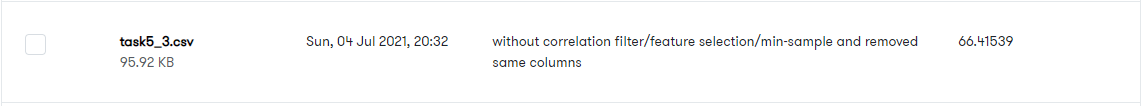